In [2]:
import numpy as np
import pickle as pkl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from aidam.miscellanea_utils import find_matlabstyle
from scipy.optimize import curve_fit


'''
from aidam.faga.faga import Faga
from aidam.faga.init_functions_repo import uniform_init
from aidam.faga.terminal_functions_repo import TF_max_generations
from aidam.faga.recomb_functions_repo import constant_recombination_rates
from aidam.faga.selection_functions_repo import tophalf_selection, ranking_selection
from aidam.faga.crossover_functions_repo import real_averaging_crossover, weighted_averaging_crossover
from aidam.faga.mutation_functions_repo import random_mutation_in_range, local_mutation_in_range
'''

from aidam.faga.curve_fit import FagaCurveFit

from aidam.math_utils import moving_function_rev1
from aidam.NbEnhance import tabprint

## Lettura dati

In [4]:
data_file='stored_data.pkl'

infile=open(data_file,'rb')
trend=pkl.load(infile)
regioni=pkl.load(infile)
giorni=pkl.load(infile)
giorno_settimana=pkl.load(infile)
infile.close()

day_counter=list(range(len(giorni)))

print('Giorni osservati: %d'%len(giorni))
print('Primo giorno: %s'%giorni[0])
print('Ultimo giorno: %s'%giorni[-1])

Giorni osservati: 78
Primo giorno: 2020-02-24T18:00:00
Ultimo giorno: 2020-05-11T17:00:00


Preparazione date

- creo il giorno0 nel formato *datetime* per poi creare i nuovi plot su questa base
- creo una lista di giorni (in formato di stringhe) partendo dal giorno0

In [5]:
giorno0=datetime.strptime(giorni[0][0:10], "%Y-%m-%d")
str_giorni=[]
for d in range(500):
    str_giorni.append((giorno0+timedelta(d)).strftime("%Y-%m-%d"))
str_giorni=np.array(str_giorni)

oggi=datetime.strftime(datetime.now(), "%Y-%m-%d")
indice_oggi=find_matlabstyle(str_giorni,lambda x:x==oggi)[0]

## Funzioni base

Si testano due versioni generalizzate della sigmoide:

- sigmoide generalizzata
- sigmoide generalizzata estesa

In [6]:
def generalized_sigmoid(t,a,b,M,alpha):
    y=M/(1+np.exp(-a*t+b))**alpha
    return y

def generalized_sigmoid_ext(t,a,b,c,M,alpha):
    y=(M+c*t)/(1+np.exp(-a*t+b))**alpha
    return y

## Fitting

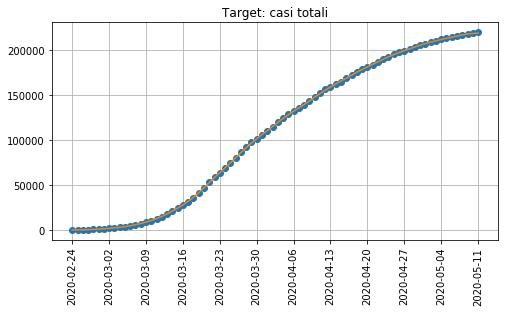

In [9]:
target_data=trend['totale_casi']['Italia']
target_data_filtered=moving_function_rev1(target_data,np.mean,2,2)

fig,ax=plt.subplots(1,1,figsize=(8,4))
ax.plot(day_counter,target_data,'o')
ax.plot(day_counter,target_data_filtered,'-')
ax.set_xticks(list(range(0,len(target_data),7)))
ax.set_title('Target: casi totali')
ax.set_xticklabels(str_giorni[list(range(0,len(target_data),7))],rotation=90)
ax.grid()

## GA-based Curve fitting


In [13]:
days_training=len(target_data)

# Italia
a_range=[0,0.25]
b_range=[0, 0.1]
c_range=[0,10]
M_range=[2e+5,3e+5]
alpha_range=[0,10]


# Regione
'''a_range=[0,0.1]
b_range=[0, 1e-5]
c_range=[0,10]
M_range=[5e+3,1e+4]
alpha_range=[0,20]
'''

dominio=np.vstack((a_range,
                   b_range,
                   c_range,
                   M_range,
                   alpha_range))
dominio=dominio.T

tabprint(dominio,digits=12,precision=2,index=['Min','Max'])

              0           1           2           3           4
           ----        ----        ----        ----        ----
Min        0.00        0.00        0.00   200000.00        0.00
Max        0.25        0.10       10.00   300000.00       10.00


In [14]:
def error_measure(predicted,actual):
    return np.mean(np.abs(predicted-actual))#+np.mean(np.abs(predicted[-3:]-actual[-3:]))


fct=FagaCurveFit()

fct.fit(generalized_sigmoid_ext, 
        np.arange(days_training),
        target_data[0:days_training],
        dominio,
        ga_generations=200, ga_population=200,
        error_function=error_measure)

solution=fct.opt_params
print(solution)

Io esisto
Gen:     0 BestAll: 0.0001954 BestGen: 0.0001954  BioDiv: 5.9e+03
Gen:    10 BestAll: 0.0003631 BestGen: 0.0003631  AveFit: 0.0001288
Gen:    20 BestAll: 0.0003631 BestGen: 0.0003631  AveFit: 0.0002514
Gen:    30 BestAll: 0.0003631 BestGen: 0.0003631  AveFit: 0.0003414
Gen:    40 BestAll: 0.0003631 BestGen: 0.0003631  AveFit: 0.0003572
Gen:    50 BestAll: 0.0003631 BestGen: 0.0003631  AveFit: 0.0003619
Gen:    60 BestAll: 0.0003631 BestGen: 0.0003631  AveFit: 0.000363
Gen:    70 BestAll: 0.0003631 BestGen: 0.0003631  AveFit: 0.0003631
Gen:    80 BestAll: 0.0003631 BestGen: 0.0003631  AveFit: 0.0003631
Gen:    90 BestAll: 0.0003631 BestGen: 0.0003631  AveFit: 0.0003631
Gen:   100 BestAll: 0.0003631 BestGen: 0.0003631  AveFit: 0.0003631
Gen:   110 BestAll: 0.0003631 BestGen: 0.0003631  AveFit: 0.0003631
Gen:   120 BestAll: 0.0003631 BestGen: 0.0003631  AveFit: 0.0003631
Gen:   130 BestAll: 0.0003631 BestGen: 0.0003631  AveFit: 0.0003631
Gen:   140 BestAll: 0.0003631 BestGen: 0.

Adesso applico il modello tunato sia ai giorni passati sia a giorni futuri.

*forecast_days* sono i giorni per cui lo applico: iniziano dal giorno 0 e finoscono quando si vuole nel futuro

In [15]:
forecast_days=np.arange(200)
y_pred=np.array(list(map(lambda x:generalized_sigmoid_ext(x,*solution),forecast_days)))

#### Plots

C:\Users\klaat\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


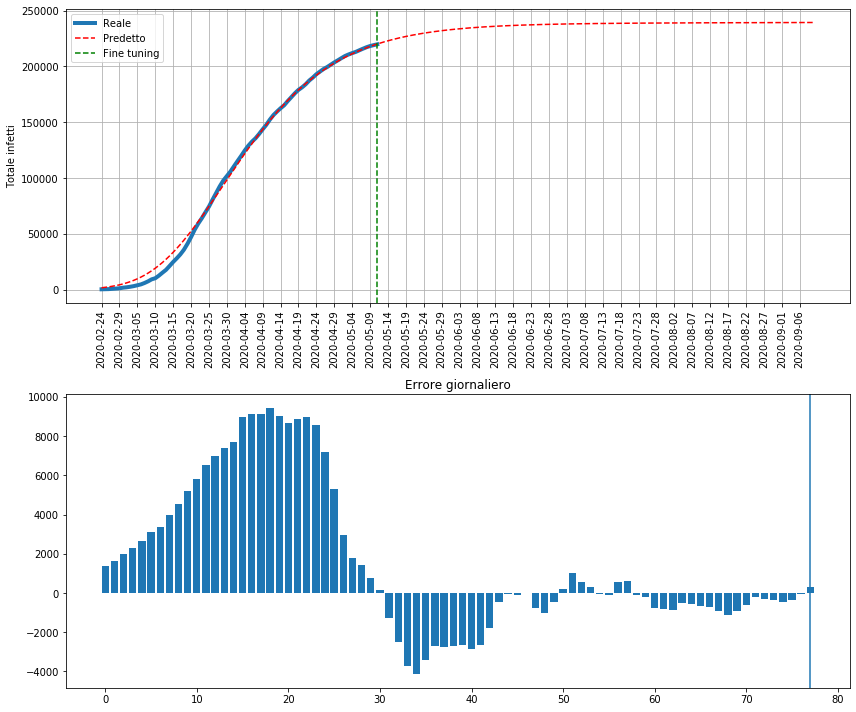

In [16]:
# preparazione palette colori
lista_colori=list(mcolors.TABLEAU_COLORS.items())
color_names=[cn[0] for cn in lista_colori]

fig,ax=plt.subplots(2,1,figsize=(12,10))
ax[0].plot(day_counter,target_data,label='Reale',linewidth=4)
ax[0].plot(forecast_days,y_pred,'r--',label='Predetto')
ax[0].axvline(days_training-1,c='g',ls='--',label='Fine tuning')
ax[0].set_xticks(list(range(0,len(forecast_days),5)))
ax[0].set_xticklabels(str_giorni[list(range(0,len(forecast_days),5))],rotation=90)
ax[0].set_ylabel('Totale infetti')
ax[0].legend()
ax[0].grid()

ax[1].bar(day_counter,y_pred[day_counter]-target_data)
ax[1].axvline(days_training-1)
ax[1].set_title('Errore giornaliero')
fig.tight_layout()
fig.show()

### Adesso vediamo, secondo il modello, quando non avremo più contagiati

In [17]:
nuovi_contagi_pred=np.diff(y_pred)

nuovi_contagi_reali=np.diff(target_data)
nuovi_contagi_reali_filtered=np.diff(target_data_filtered)


soglie_contagi=[1000,500,100,10]
giorni_soglia=[]
for soglia in soglie_contagi:
    nuovi_contagi_sotto_soglia=[i for i,nc in enumerate(nuovi_contagi_pred) if (i>30 and nc<=soglia)]
    giorni_soglia.append(nuovi_contagi_sotto_soglia[0])



Soglia:  1000   Giorno:   78 [2020-05-12]
Soglia:   500   Giorno:   90 [2020-05-24]
Soglia:   100   Giorno:  120 [2020-06-23]
Soglia:    10   Giorno:  177 [2020-08-19]


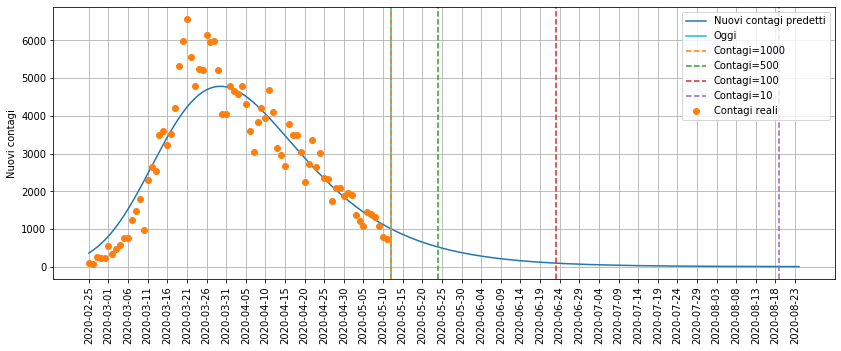

In [18]:
fig,ax=plt.subplots(1,1,figsize=(14,5))
ax.plot(range(max(giorni_soglia)+5),nuovi_contagi_pred[0:max(giorni_soglia)+5],label='Nuovi contagi predetti')
ax.set_ylabel('Nuovi contagi')
ax.axvline(indice_oggi-1,label='Oggi',c=color_names[9])
for i,soglia in enumerate(soglie_contagi):
    ax.axvline(giorni_soglia[i]-1,label='Contagi=%d'%soglia,c=color_names[i+1],linestyle='--')

ax.plot(nuovi_contagi_reali,'o',label='Contagi reali')
#ax.plot(nuovi_contagi_reali_filtered,'+',label='Contagi reali filt.')
    
ax.set_xticks(list(range(0,max(giorni_soglia)+5,5)))
ax.set_xticklabels(str_giorni[list(range(1,len(forecast_days),5))],rotation=90)
ax.grid()
ax.legend()

for i,soglia in enumerate(soglie_contagi):
    print('Soglia: %5d   Giorno: %4d [%10s]'%(soglia,giorni_soglia[i],str_giorni[giorni_soglia[i]]))